# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD)    (Note: Also called FISTA in the lecture slides!)

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- Since many students are not currently registered on moodle, we are still choosing how you will submit the final notebook. We will e-mail you before **1st of  October** on how to submit the final notebook.
- Deadline for submission is the **4th of october at 21:59**
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Manon"
ln1 = "Verbockhaven"
fn2 = "Theo"
ln2 = "Jolivet"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_verbockhaven_manon_and_jolivet_theo.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

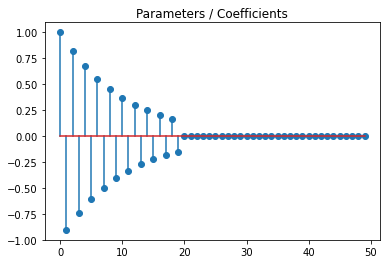

In [4]:
n_features = 50   
n_samples = 1000  
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0. # Set parameters after index 20 to zero (sparse coefficients generation)
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
A, b = simu_linreg(coefs);
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course (using separability) or find a smart way to rewrite it in one line with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 penalization at x"""
    z = np.zeros(len(A[0]))
    z = np.sign(x) * np.maximum(np.abs(x) - lmbd, 0.)
    return z

def L1_pen(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.sum(np.abs(x)) 

def prox_L2(x, lmbd):
    """Proximal operator for the L2 penalization at x"""
    z = x/(1 + lmbd) 
    return z

def L2_pen(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd/2*np.sum(np.abs(x)**2) # We take lmbd/2 by convention

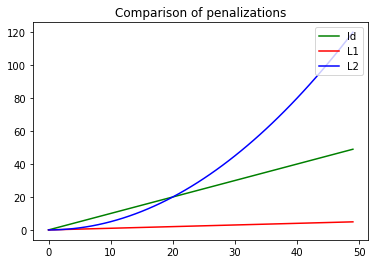

In [17]:
lam = 0.1
Y_P1 = [prox_L1(A[i], lam) for i in range(0, len(A))]
Y_L1 = [L1_pen(A[i], lam) for i in range(0, len(A))]

Y_P2 = [prox_L2(A[i], lam) for i in range(0, len(A))]
Y_L2 = [L2_pen(A[i], lam) for i in range(0, len(A))]

#plt.plot(Y_L1, Y_P1,'o', color = 'red', label = 'L1')
#plt.plot(Y_L2, Y_P2, 'o', color = 'green', label = 'L2')

a = np.arange(50)
Y_L1 = [L1_pen(i, lam) for i in range(50)]
Y_L2 = [L2_pen(i, lam) for i in range(50)]

plt.plot(a, a,'-', color = 'green', label = 'Id')
plt.plot(a, Y_L1,'-', color = 'red', label = 'L1')
plt.plot(a, Y_L2,'-', color = 'blue', label = 'L2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', prop={'size': 10})
plt.title('Comparison of penalizations')

plt.show()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be

(-2.0, 2.0)

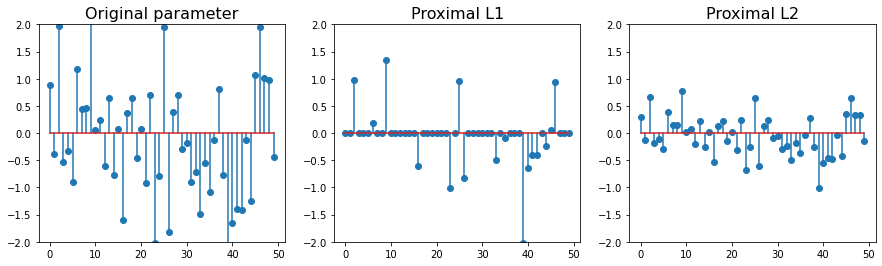

In [18]:
x = randn(50)
l_l1 = 1.
l_l2 = 2 #prb 

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<li> The Proximal operator for L2 minimizes the energy of the values whereas the proximal operator for L1 seeks a sparse solution by mapping many coefficients to zero (soft thresholding). The regularization parameter corresponds to the tradeoff between the fidelity and regularization terms. If lambda is zero, the proximal operator of lambda R maps x to the closest point to it. If lambda tends to a great value, we aim at minimizing R but not being close to zero.  </li>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [19]:
def f_linreg(x):
    """Least squares loss"""
    return np.sum(np.abs(b-np.dot(A,x))**2)/ 2/ len(A)

def grad_f_linreg(x):
    """Least squares gradient"""
    return np.dot(A.T,(np.dot(A,x) - b))/len(A)

def f_logreg(x):
    """Logistic loss"""
    return sum(np.log(1 + np.exp(-b[i] * np.dot(A[i], x))) for i in range(0, len(A)))/len(A)

def grad_f_logreg(x):
    """Logistic gradient"""
    return sum(-b[i]*A[i].T * np.exp(-b[i]*np.dot(A[i], x))/(1 + np.exp(-b[i]*np.dot(A[i], x))) for i in range(0, len(A)))/len(A)

In [21]:
# Verification
from scipy.optimize import check_grad
S = 0
for i in range(0, 100) :
    S += check_grad(f_linreg, grad_f_linreg, np.random.rand(50))
print('mean err linear:', S/100)

S = 0
for i in range(0, 100) :
    S += check_grad(f_logreg, grad_f_logreg, np.random.rand(50))
print('mean err log:', S/100)

mean err linear: 1.2381138641071234e-06
mean err log: 1.7896940637387884e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [22]:
# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    
    return np.linalg.svd(np.dot(A, A.T))[1][0]

# Calculate the smoothness constant for logistic loss    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.svd(A)[1][0]**2 / 4 / len(A)
        
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    L = 1/step
    
    for k in range(n_iter + 1):
        x = prox_R(x - 1 / L * grad_f(x), lmbd/L)
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [23]:
""" Also called FISTA in the lecture slides """
def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_save = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    

    t = 1.
    t_save = 1.

    L = 1/step
    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_save = x.copy()
        x = prox_R(z - 1 /L * grad_f(z), lmbd / L)
        
        t_save = float(t)
        t = (1 + np.sqrt(1 + 4*t_save**2))/2
        
        z = x + (t_save - 1) / t * (x - x_save)
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 100 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [24]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [25]:
print('linear')
x0 = np.zeros(len(A[0]))

step = (1 / smoothness_const_linreg(A))
x_star, objectives, errors = PGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

x_star_A, objectives_A, errors_A = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

linear
Lauching PGD solver...
   it    |   obj    |   err   
       0 | 1.51e+00 | 1.00e+00
     100 | 1.48e+00 | 9.88e-01
     200 | 1.44e+00 | 9.76e-01
     300 | 1.41e+00 | 9.65e-01
     400 | 1.38e+00 | 9.54e-01
     500 | 1.35e+00 | 9.43e-01
     600 | 1.32e+00 | 9.32e-01
     700 | 1.30e+00 | 9.22e-01
     800 | 1.27e+00 | 9.11e-01
     900 | 1.25e+00 | 9.01e-01
    1000 | 1.22e+00 | 8.91e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.51e+00 | 1.00e+00
     100 | 1.14e+00 | 8.52e-01
     200 | 7.04e-01 | 5.48e-01
     300 | 5.10e-01 | 2.63e-01
     400 | 4.83e-01 | 1.45e-01
     500 | 4.89e-01 | 1.42e-01
     600 | 4.83e-01 | 1.24e-01
     700 | 4.79e-01 | 1.25e-01
     800 | 4.80e-01 | 1.46e-01
     900 | 4.80e-01 | 1.49e-01
    1000 | 4.79e-01 | 1.34e-01


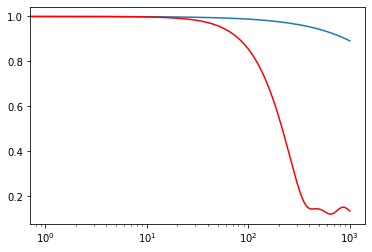

In [27]:
plt.plot(np.arange(len(errors)), errors)
plt.plot(np.arange(len(errors_A)), errors_A, color = 'red')
plt.xscale("log")

As we could have assumed, the convergence of FISTA is much quicker than the convergence of PGD.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


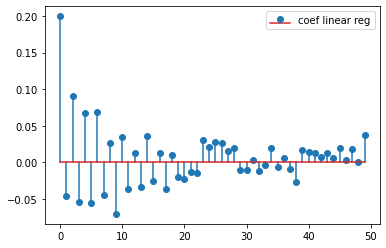

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


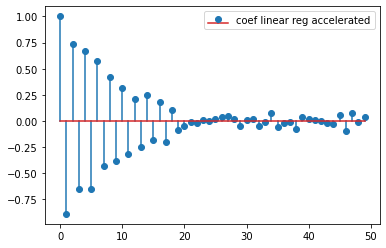

In [31]:
plt.stem(x_star, label = 'coef linear reg')
plt.legend()
plt.show()
plt.stem(x_star_A, label = 'coef linear reg accelerated')
plt.legend()
plt.show()
#plt.stem(objectives)

We can see two things in those plots: 1) the accelerated gradient descent (bottom plot) converged quicker and is closer to the true solution and 2) the L2 penalization doesn't set the coefficients after 20 to zero like the L1 penalization would.

**Correlation Linear regression**

From now on we only use FISTA as in this case it provides the same results but quicker.

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.47e+00 | 9.99e-01
     100 | 7.78e-01 | 3.13e-01
     200 | 5.62e-01 | 1.52e-01
     300 | 5.36e-01 | 1.04e-01
     400 | 5.32e-01 | 1.03e-01
     500 | 5.30e-01 | 9.94e-02
     600 | 5.30e-01 | 9.74e-02
     700 | 5.29e-01 | 9.94e-02
     800 | 5.29e-01 | 9.62e-02
     900 | 5.29e-01 | 9.90e-02
    1000 | 5.29e-01 | 9.64e-02
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 2.59e+00 | 9.99e-01
     100 | 8.77e-01 | 4.61e-01
     200 | 5.24e-01 | 1.22e-01
     300 | 5.06e-01 | 9.30e-02
     400 | 5.06e-01 | 1.10e-01
     500 | 5.04e-01 | 9.06e-02
     600 | 5.03e-01 | 9.09e-02
     700 | 5.03e-01 | 9.49e-02
     800 | 5.03e-01 | 9.10e-02
     900 | 5.03e-01 | 9.03e-02
    1000 | 5.03e-01 | 9.24e-02
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 2.30e+00 | 1.00e+00
     100 | 1.07e+00 | 5.85e-01
     200 | 5.08e-01 | 1.28e-01
     300 | 5.19e-01 | 1.34e-01
     400 | 5.05e-01 | 1.04e-0

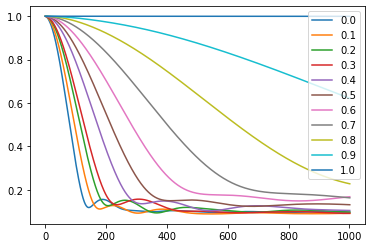

In [32]:
for my_corr in [0.1 * i for i in range(11)] :
    A, b = simu_linreg(coefs, n_samples=1000, corr = my_corr)
        

    x0 = np.zeros(len(A[0]))

    step = (1 / smoothness_const_linreg(A))
    x_star_A, objectives_A, errors_A =APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

    plt.plot(np.arange(len(errors_A)), errors_A, label = str(np.round(my_corr, 1)))
plt.legend()
plt.show()

By plotting the convergence rate in function of the iteration for many correlation values, we see that the less correlation there is between data, the quicker the convergence. It might come from the fact that any element in the vector brings "new" information because they're all uncorrelated.

**Correlation Logistic regression**

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 9.99e-01
     100 | 6.93e-01 | 9.99e-01
     200 | 6.93e-01 | 9.99e-01
     300 | 6.93e-01 | 9.99e-01
     400 | 6.93e-01 | 9.99e-01
     500 | 6.93e-01 | 9.99e-01
     600 | 6.93e-01 | 9.99e-01
     700 | 6.93e-01 | 9.99e-01
     800 | 6.93e-01 | 9.99e-01
     900 | 6.93e-01 | 9.99e-01
    1000 | 6.93e-01 | 9.99e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 9.99e-01
     100 | 6.93e-01 | 9.99e-01
     200 | 6.93e-01 | 9.99e-01
     300 | 6.93e-01 | 9.99e-01
     400 | 6.93e-01 | 9.99e-01
     500 | 6.93e-01 | 9.99e-01
     600 | 6.93e-01 | 9.99e-01
     700 | 6.93e-01 | 9.99e-01
     800 | 6.93e-01 | 9.99e-01
     900 | 6.93e-01 | 9.99e-01
    1000 | 6.93e-01 | 9.99e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 9.99e-01
     100 | 6.93e-01 | 9.99e-01
     200 | 6.93e-01 | 9.99e-01
     300 | 6.93e-01 | 9.99e-01
     400 | 6.93e-01 | 9.99e-0

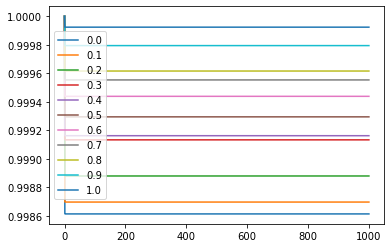

In [36]:
for my_corr in [0.1 * i for i in range(11)] :
    A, b = simu_logreg(coefs, n_samples=1000, corr = my_corr)
        

    x0 = np.zeros(len(A[0]))

    step = (1 / smoothness_const_loreg(A))
    x_star_A, objectives_A, errors_A =APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

    plt.plot(np.arange(len(errors_A)), errors_A, label = str(np.round(my_corr, 1)))
plt.legend()
plt.show()

The convergence is quicker when the correlation goes to zero for the linear and the logistic regression. We double-checked with PGD and had the same results with a slower convergence speed.

**L2 Penalization linear regression**

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.45e+00 | 1.00e+00
     100 | 1.13e+00 | 8.58e-01
     200 | 7.17e-01 | 5.54e-01
     300 | 5.10e-01 | 2.53e-01
     400 | 4.75e-01 | 1.29e-01
     500 | 4.81e-01 | 1.55e-01
     600 | 4.77e-01 | 1.45e-01
     700 | 4.72e-01 | 1.27e-01
     800 | 4.72e-01 | 1.29e-01
     900 | 4.72e-01 | 1.23e-01
    1000 | 4.71e-01 | 1.10e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.45e+00 | 1.00e+00
     100 | 1.13e+00 | 8.59e-01
     200 | 7.26e-01 | 5.56e-01
     300 | 5.30e-01 | 2.59e-01
     400 | 5.02e-01 | 1.24e-01
     500 | 5.07e-01 | 1.33e-01
     600 | 5.02e-01 | 1.25e-01
     700 | 4.98e-01 | 1.26e-01
     800 | 4.98e-01 | 1.39e-01
     900 | 4.98e-01 | 1.33e-01
    1000 | 4.97e-01 | 1.15e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.45e+00 | 1.00e+00
     100 | 1.14e+00 | 8.60e-01
     200 | 7.99e-01 | 5.77e-01
     300 | 6.85e-01 | 3.23e-01
     400 | 6.86e-01 | 1.97e-0

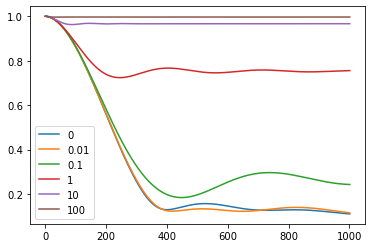

In [42]:
A, b = simu_linreg(coefs, n_samples=1000)
for lmbd in [0, 0.01, 0.1, 1, 10, 100] :
    x0 = np.zeros(len(A[0]))

    step = (1 / smoothness_const_linreg(A))
    x_star_A, objectives_A, errors_A = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
    
    plt.plot(np.arange(len(errors_A)), errors_A, label = str(lmbd))
plt.legend()
plt.show()

When lambda is too large, FISTA doesn't converge as the penalization is too important and the coefficients are mapped to zero. But this plot doesn't show everything, we must also plot x_star_A to make sure the cost function isn't too skewed and find a tradeoff between the fidelity and regularization term.

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.59e+00 | 1.00e+00
     100 | 1.25e+00 | 8.48e-01
     200 | 8.47e-01 | 5.44e-01
     300 | 7.25e-01 | 2.91e-01
     400 | 7.28e-01 | 1.94e-01
     500 | 7.25e-01 | 2.00e-01
     600 | 7.20e-01 | 2.47e-01
     700 | 7.21e-01 | 2.76e-01
     800 | 7.20e-01 | 2.67e-01
     900 | 7.19e-01 | 2.43e-01
    1000 | 7.19e-01 | 2.32e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.59e+00 | 1.00e+00
     100 | 1.54e+00 | 9.60e-01
     200 | 1.54e+00 | 9.62e-01
     300 | 1.54e+00 | 9.63e-01
     400 | 1.54e+00 | 9.63e-01
     500 | 1.54e+00 | 9.63e-01
     600 | 1.54e+00 | 9.63e-01
     700 | 1.54e+00 | 9.63e-01
     800 | 1.54e+00 | 9.63e-01
     900 | 1.54e+00 | 9.63e-01
    1000 | 1.54e+00 | 9.63e-01


/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


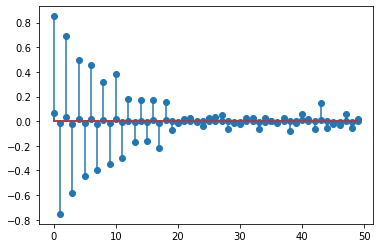

In [45]:
A, b = simu_linreg(coefs, n_samples=1000)

lmbd = 0.1
x0 = np.zeros(len(A[0]))
step = (1 / smoothness_const_linreg(A))

x_star_A, objectives_A, errors_A =APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)
    
plt.stem(x_star_A)

lmbd = 10

x_star_A, objectives_A, errors_A =APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.stem(x_star_A)
plt.show()

With this plot it's very clear that for a regularization parameter value that would be **too large**, we are not minimizing the fidelity term anymore but projetting every coefficient to zero to minimize the penalization term.

**L2 Penalization logistic regression**

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.55e-01 | 9.24e-01
     100 | 5.29e-01 | 3.34e-01
     200 | 5.29e-01 | 3.35e-01
     300 | 5.29e-01 | 3.35e-01
     400 | 5.29e-01 | 3.35e-01
     500 | 5.29e-01 | 3.35e-01
     600 | 5.29e-01 | 3.35e-01
     700 | 5.29e-01 | 3.35e-01
     800 | 5.29e-01 | 3.35e-01
     900 | 5.29e-01 | 3.35e-01
    1000 | 5.29e-01 | 3.35e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.56e-01 | 9.24e-01
     100 | 5.52e-01 | 3.45e-01
     200 | 5.52e-01 | 3.45e-01
     300 | 5.52e-01 | 3.45e-01
     400 | 5.52e-01 | 3.45e-01
     500 | 5.52e-01 | 3.45e-01
     600 | 5.52e-01 | 3.45e-01
     700 | 5.52e-01 | 3.45e-01
     800 | 5.52e-01 | 3.45e-01
     900 | 5.52e-01 | 3.45e-01
    1000 | 5.52e-01 | 3.45e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.61e-01 | 9.32e-01
     100 | 6.22e-01 | 6.84e-01
     200 | 6.22e-01 | 6.84e-01
     300 | 6.22e-01 | 6.84e-01
     400 | 6.22e-01 | 6.84e-0

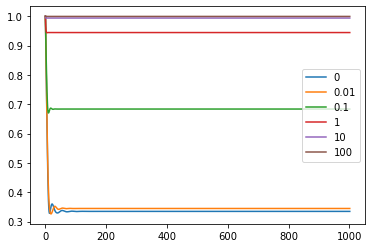

In [38]:
A, b = simu_logreg(coefs, n_samples=1000)
for lmbd in [0, 0.01, 0.1, 1, 10, 100] :
    x0 = np.zeros(len(A[0]))

    step = (1 / smoothness_const_loreg(A))
    x_star_A, objectives_A, errors_A =APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
    
    plt.plot(np.arange(len(errors_A)), errors_A, label = str(lmbd))
plt.legend()
plt.show()

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.52e+00 | 1.00e+00
     100 | 1.18e+00 | 8.54e-01
     200 | 8.15e-01 | 5.65e-01
     300 | 6.99e-01 | 3.12e-01
     400 | 7.01e-01 | 2.02e-01
     500 | 6.99e-01 | 2.10e-01
     600 | 6.94e-01 | 2.63e-01
     700 | 6.95e-01 | 2.96e-01
     800 | 6.94e-01 | 2.87e-01
     900 | 6.93e-01 | 2.60e-01
    1000 | 6.94e-01 | 2.47e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.52e+00 | 1.00e+00
     100 | 1.22e+00 | 8.62e-01
     200 | 1.05e+00 | 6.46e-01
     300 | 1.05e+00 | 5.53e-01
     400 | 1.04e+00 | 5.84e-01
     500 | 1.04e+00 | 6.19e-01
     600 | 1.04e+00 | 6.05e-01
     700 | 1.04e+00 | 5.87e-01
     800 | 1.04e+00 | 5.95e-01
     900 | 1.04e+00 | 6.06e-01
    1000 | 1.04e+00 | 6.00e-01


/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


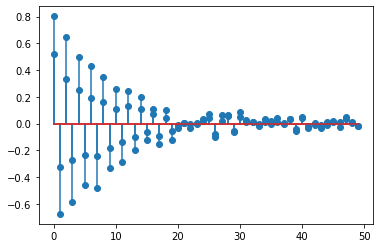

In [47]:
A, b = simu_linreg(coefs, n_samples=1000)

lmbd = 0.1
x0 = np.zeros(len(A[0]))
step = (1 / smoothness_const_linreg(A))

x_star_A, objectives_A, errors_A =APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)
    
plt.stem(x_star_A)

lmbd = 0.5

x_star_A, objectives_A, errors_A =APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.stem(x_star_A)
plt.show()

We can make the same conclusions for the logistic regression.

**Comparison between norms**

For the linear regression

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.43e+00 | 1.00e+00
     100 | 1.11e+00 | 8.61e-01
     200 | 7.21e-01 | 5.71e-01
     300 | 5.56e-01 | 2.91e-01
     400 | 5.38e-01 | 1.34e-01
     500 | 5.43e-01 | 9.94e-02
     600 | 5.37e-01 | 1.14e-01
     700 | 5.34e-01 | 1.62e-01
     800 | 5.35e-01 | 1.90e-01
     900 | 5.34e-01 | 1.81e-01
    1000 | 5.33e-01 | 1.54e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.43e+00 | 1.00e+00
     100 | 1.20e+00 | 8.85e-01
     200 | 9.04e-01 | 6.47e-01
     300 | 7.74e-01 | 4.16e-01
     400 | 7.53e-01 | 2.72e-01
     500 | 7.58e-01 | 2.21e-01
     600 | 7.54e-01 | 2.29e-01
     700 | 7.51e-01 | 2.70e-01
     800 | 7.52e-01 | 3.04e-01
     900 | 7.51e-01 | 3.06e-01
    1000 | 7.50e-01 | 2.86e-01


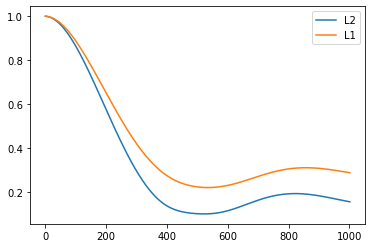

In [67]:
lmbd = 0.04
corr = 0.5
A, b = simu_linreg(coefs, n_samples=1000)

x0 = np.zeros(len(A[0]))

step = (1 / smoothness_const_linreg(A))
x_star_A, objectives_A, errors_A = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.plot(np.arange(len(errors_A)), errors_A, label = 'L2')

x_star_A, objectives_A, errors_A = APGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.plot(np.arange(len(errors_A)), errors_A, label = 'L1')
plt.legend()
plt.show()

Because we want to solve the inverse problem and estimate the initial function, we want all its values with index > 20 to be zero and the L1 penalization is more appropriate. Nevertheless, the regularization parameter should be chosen carefully because the soft thresholding would map all values to zero would lambda be too large. Note that if lambda is zero, both regularizations bring the same results.

For the logistic regression

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.53e-01 | 9.17e-01
     100 | 5.77e-01 | 4.83e-01
     200 | 5.77e-01 | 4.83e-01
     300 | 5.77e-01 | 4.83e-01
     400 | 5.77e-01 | 4.83e-01
     500 | 5.77e-01 | 4.83e-01
     600 | 5.77e-01 | 4.83e-01
     700 | 5.77e-01 | 4.83e-01
     800 | 5.77e-01 | 4.83e-01
     900 | 5.77e-01 | 4.83e-01
    1000 | 5.77e-01 | 4.83e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 6.85e-01 | 9.74e-01
     100 | 6.72e-01 | 8.51e-01
     200 | 6.72e-01 | 8.51e-01
     300 | 6.72e-01 | 8.51e-01
     400 | 6.72e-01 | 8.51e-01
     500 | 6.72e-01 | 8.51e-01
     600 | 6.72e-01 | 8.51e-01
     700 | 6.72e-01 | 8.51e-01
     800 | 6.72e-01 | 8.51e-01
     900 | 6.72e-01 | 8.51e-01
    1000 | 6.72e-01 | 8.51e-01


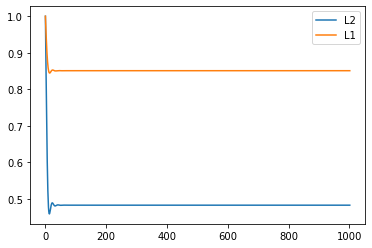

In [69]:
lmbd = 0.04
corr = 0.5
A, b = simu_logreg(coefs, n_samples=1000)

x0 = np.zeros(len(A[0]))

step = (1 / smoothness_const_loreg(A))
x_star_A, objectives_A, errors_A = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.plot(np.arange(len(errors_A)), errors_A, label = 'L2')

x_star_A, objectives_A, errors_A = APGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step, lmbd=lmbd, n_iter=n_iter,
        x_true=coefs, verbose=True)

plt.plot(np.arange(len(errors_A)), errors_A, label = 'L1')
plt.legend()
plt.show()

The choice of the penalization should come from the objective of the gradient descent. From a bayesian standpoint, it corresponds to a prior knowledge on the cost function. If we want to minimize an energy at every pixel (for example, we want to estimate the electric field from its intensity), we use the L2 penalisation. If we know the solution is sparse (for example, we want to recover only a few elements from a sparse dictionnary), we use the L1 penalization. As we saw from the plot of "coeffs" earlier, elements with an index superior to 20 are set to zero, so the L1 norm is more appropriate. In practice, we don't necessarily have access to that information when computing the gradient descent and choosing a cost function.